<a href="https://colab.research.google.com/github/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
!wget https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/FullAndFracture.zip

--2022-11-18 10:28:25--  https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/FullAndFracture.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘FullAndFracture.zip.1’

FullAndFracture.zip     [ <=>                ] 138.36K  --.-KB/s    in 0.02s   

2022-11-18 10:28:25 (5.66 MB/s) - ‘FullAndFracture.zip.1’ saved [141676]



In [5]:
!unzip /content/FullAndFracture.zip

Archive:  /content/FullAndFracture.zip
  inflating: FullAndFracture.npy     


In [2]:
data = np.load('FullAndFracture.npy')

In [3]:
data.shape #completo|fracturado, modelos, objeto

(2, 7112, 32, 32, 32)

In [5]:
X = data[1] #fracturado
Y = data[0] #completo

In [6]:
def bbvox_points(obj):
  points = []
  for z in range(32):
    for y in range(32):
      for x in range(32):
        if obj[x,y,z]:
          points += [ (x,y,z) ]
  return np.array(points)

def showArr3DC(points, pos=1):
  # plt.subplots(figsize=(6,6))
  ax = plt.subplot(1, 3, pos, projection='3d' )
  ax.scatter3D(points[:,0], points[:,1], points[:,2], c='black')

def showArr3DBoolC(obj, pos=1):
  showArr3DC( bbvox_points(obj), pos )

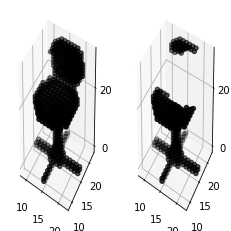

In [7]:
#@title Visualizar {run: "auto"}
id = 283 #@param {type: 'slider', max:888, min:0, step:1}
showArr3DBoolC(Y[id], 1) #completo
showArr3DBoolC(X[id], 2) #fracturado

# DCGAN - Pytorch

In [7]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset, Dataset

from torchvision.transforms import ToTensor
from torch import optim
from torch.autograd import Variable

import matplotlib.pyplot as plt

In [8]:
torch.manual_seed(0)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
def show_tensor_images(image_tensor, size, pos, num_images=9):
  image_unflat = image_tensor.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=3)
  showArr3DBoolC( image_grid.permute(1, 2, 0).squeeze(), pos )

In [11]:
def get_noise(n_samples, z_dim, device='cpu'):
  return torch.randn(n_samples, z_dim, device=device)

## Convolucional

In [96]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1,
                                          out_channels=32,
                                          kernel_size=3),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2))
    self.conv2 = nn.Sequential(nn.Conv2d(in_channels=32,
                                          out_channels=64,
                                          kernel_size=3),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2))
    self.out = nn.Linear(64 * 5 * 5, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.size(0), -1)
    output = self.out(x)
    return output, x

  # def backward(self, x):
  #   x = self.conv2(x)
  #   x = self.conv1(x)
  #   x = x.view(x.size(0), -1)
  #   output = self.out(x)
  #   return output, x

In [ ]:
cnn = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.01)

print(cnn, loss_func, optimizer)

## Generador

In [12]:
def get_generator_block(input_dim, output_dim):
  return nn.Sequential(
    nn.Linear(input_dim, output_dim),
    nn.BatchNorm1d(output_dim),
    nn.ReLU(inplace=True)
  )

In [13]:
class Generator(nn.Module):
  def __init__(self, z_dim=10, im_dim=28*28, hidden_dim=128):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
      get_generator_block(z_dim, hidden_dim),
      get_generator_block(hidden_dim, hidden_dim*2),
      get_generator_block(hidden_dim*2, hidden_dim*4),
      get_generator_block(hidden_dim*4, hidden_dim*8),
      nn.Linear(hidden_dim*8, im_dim),
      nn.Sigmoid()
    )

  def forward(self, noise):
    return self.gen(noise)

  def get_gen(self):
    return self.gen

In [14]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
  fake_noise = get_noise(num_images, z_dim, device=device)
  fake = gen(fake_noise)
  disc_fake_pred = disc(fake)
  gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
  return gen_loss

## Discriminador

In [15]:
def get_discriminator_block(input_dim, output_dim):
  return nn.Sequential(
    nn.Linear(input_dim, output_dim),
    nn.LeakyReLU(0.2, inplace=True)
  )

In [16]:
class Discriminator(nn.Module):
  def __init__(self, im_dim=28*28, hidden_dim=128):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
      get_discriminator_block(im_dim, hidden_dim * 4),
      get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
      get_discriminator_block(hidden_dim * 2, hidden_dim),
      nn.Linear(hidden_dim, 1)
    )

  def forward(self, image):
    return self.disc(image)

  def get_disc(self):
    return self.disc

In [17]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
  fake_noise = get_noise(num_images, z_dim, device=device)
  fake = gen(fake_noise)
  disc_fake_pred = disc(fake.detach())
  disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
  disc_real_pred = disc(real)
  disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
  disc_loss = (disc_fake_loss + disc_real_loss) / 2
  return disc_loss

## Guardar modelo

In [18]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [19]:
drive_folder = '/gdrive/MyDrive/UPC-CC/6. Machine Learning/'

In [28]:
def save_model(n):
  torch.save(disc.state_dict(), f'{drive_folder}disc_{n}.pth')
  torch.save(gen.state_dict(), f'{drive_folder}gen_{n}.pth')
  print(f'disc_{n}.pth and gen_{n}.pth were saved.')

## Aplicación

**Dataset**

In [141]:
# class CustomDataset(Dataset):
#   def __init__(self, x, y):
#     self.data = x
#     self.labels = y

#   def __len__(self):
#     return len(self.labels)

#   def __getitem__(self, idx):
#     image = self.data[idx]
#     label = self.labels[idx]
#     return image, label

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.7)

In [21]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

In [22]:
train_data = TensorDataset(x_train, y_train) #CustomDataset
test_data = TensorDataset(x_test, y_test) #CustomDataset

In [23]:
size = (32,32,32)
im_dim = 32**3
hidden_dim = 128

In [24]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 20
z_dim = 64
save_epoch = 4 #@param {type:'slider', min:1, max:200, step:1}
display_step = 500 #@param {type:'slider', min:500, max:1000, step:1}
batch_size = 128 #@param {type:'slider', min:16, max:256, step:1}
lr = 0.00001
device = 'cuda'
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [25]:
gen = Generator(z_dim, im_dim, hidden_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_dim, hidden_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [31]:
def train(last_step=0, last_epoch=0):
  cur_step = last_step
  mean_generator_loss = 0
  mean_discriminator_loss = 0
  test_generator = True
  gen_loss = False
  error = False

  for epoch in range(last_epoch,n_epochs):
    for real, _ in tqdm(dataloader):
      cur_batch_size = len(real)
      real = real.view(cur_batch_size, -1).to(device)
      disc_opt.zero_grad()
      disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
      disc_loss.backward(retain_graph=True)
      disc_opt.step()
      if test_generator:
        old_generator_weights = gen.gen[0][0].weight.detach().clone()

      gen_opt.zero_grad()
      gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
      gen_loss.backward()
      gen_opt.step()
      if test_generator:
        try:
          assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
          assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
        except:
          error = True
          print("Failure runtime stuff")

      #Display
      mean_discriminator_loss += disc_loss.item() / display_step
      mean_generator_loss += gen_loss.item() / display_step
      if cur_step % display_step == 0 and cur_step > 0:
        print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        show_tensor_images(fake, size, 1)
        show_tensor_images(real, size, 3)
        mean_generator_loss = 0
        mean_discriminator_loss = 0
      cur_step += 1
    
    #Save
    if epoch % save_epoch == 0 and epoch > 0:
      save_model(epoch//save_epoch)
      print(f'Epoch: {epoch} / {n_epochs}')

  0%|          | 0/39 [00:00<?, ?it/s]

Step 500: Generator loss: 0.010541631698608398, discriminator loss: 7.817019522190093e-05


  0%|          | 0/39 [00:00<?, ?it/s]

disc_3.pth and gen_3.pth were saved.
Epoch: 12 / 20


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

disc_4.pth and gen_4.pth were saved.
Epoch: 16 / 20


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

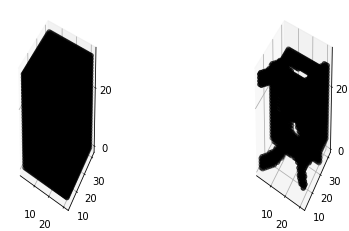

In [32]:
train(last_step=500, last_epoch=11)

# Testing

In [2]:
!wget https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/broken_chair.npy?raw=true -O broken_chair.npy

--2022-11-18 06:31:10--  https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/broken_chair.npy?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/raw/main/data/broken_chair.npy [following]
--2022-11-18 06:31:10--  https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/raw/main/data/broken_chair.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Coralain10/ML_Archaeological-Objects-Reconstruction/main/data/broken_chair.npy [following]
--2022-11-18 06:31:10--  https://raw.githubusercontent.com/Coralain10/ML_Archaeological-Objects-Reconstruction/main/data/broken_chair.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.1

In [4]:
filename = 'broken_chair.npy' #@param {type:'string'}
array = np.load(filename)